# Görüntü İşleme Projesi: Alt Giyim vs Üst Giyim Sınıflandırma
**Ad Soyad:** Özge Zara Özçelik
**Okul No:** 2212721014

## Model 2: Temel CNN (Sıfırdan Eğitim)
Bu aşamada, transfer learning veya hazır ağırlıklar kullanılmadan, **Evrişimli Sinir Ağı (CNN)** mimarisi sıfırdan tasarlanmıştır. Amaç, veri setimiz üzerinde temel bir modelin (Baseline) performansını gözlemlemektir.

1. Veri Ön İşleme ve Hazırlık Aşaması
Bu bölümde, veri setinin modele verilmeden önce geçirdiği hazırlık süreçleri ve eğitim takibi için gerekli yardımcı fonksiyonlar tanımlanmıştır.

1.1. Veri Normalizasyonu (Rescaling): Ham görüntülerde piksel değerleri 0-255 arasındadır. Derin öğrenme modellerinin daha hızlı ve kararlı (stable) bir şekilde optimize olabilmesi için ImageDataGenerator kullanılarak bu değerler 0-1 aralığına indirgenmiştir (rescale=1./255).

1.2. Eğitim ve Doğrulama Ayrımı (Validation Split): Modelin daha önce hiç görmediği veriler üzerindeki performansını ölçebilmek için veri seti %80 Eğitim (Training) ve %20 Doğrulama (Validation) olacak şekilde ikiye ayrılmıştır.

Girdi Boyutu: Tüm görüntüler, kuracağımız CNN mimarisinin giriş katmanına uygun olarak 128x128 piksel boyutuna yeniden ölçeklendirilmiştir.

Veri Artırma (Data Augmentation): Bu aşamada (Model 2 için), modelin saf performansını gözlemlemek amacıyla herhangi bir veri artırma (döndürme, kaydırma vb.) işlemi uygulanmamıştır.

1.3. Performans İzleme Aracı: Eğitim sürecini görselleştirmek için özel bir grafik_ciz fonksiyonu tanımlanmıştır. Bu fonksiyon, her epoch sonunda modelin Başarı (Accuracy) ve Yitim (Loss) değerlerini grafikleştirerek olası overfitting (ezberleme) durumlarını analiz etmemizi sağlar.

In [ ]:
# 1. Drive Bağlantısı ve Kütüphaneler
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
import os

# 2. Veri Yolu
base_dir = '/content/drive/My Drive/makine_ogrenmesi_veriseti'

# 3. Grafik Fonksiyonu (Tekrar tanımlıyoruz)
def grafik_ciz(history, model_adi):
    plt.figure(figsize=(10, 3))
    # Doğruluk
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Eğitim')
    plt.plot(history.history['val_accuracy'], label='Test')
    plt.title(f'{model_adi} - Doğruluk')
    plt.legend()
    # Kayıp
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Eğitim')
    plt.plot(history.history['val_loss'], label='Test')
    plt.title(f'{model_adi} - Kayıp')
    plt.legend()
    plt.show()

# 4. Veri Yükleyici
# Model 2 için standart yükleme (Augmentation yok)
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir, target_size=(128, 128), batch_size=32,
    class_mode='categorical', subset='training'
)

validation_generator = datagen.flow_from_directory(
    base_dir, target_size=(128, 128), batch_size=32,
    class_mode='categorical', subset='validation'
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 359 images belonging to 2 classes.
Found 88 images belonging to 2 classes.


2. Model Tasarımı: Özelleştirilmiş CNN
Bu aşamada, CIFAR-10 gibi klasik problemlerde başarısı kanıtlanmış, basit ama etkili bir mimari sıfırdan (from scratch) tasarlanmıştır.

Conv2D (Evrişim): 32'den başlayıp 64'e çıkan filtre sayısıyla görüntünün kenar, köşe ve doku haritası çıkarılmıştır.

MaxPooling2D: Her blokta boyut yarıya indirilerek işlem yükü azaltılmış ve en belirgin özelliklerin kalması sağlanmıştır.

Dense (Sınıflandırma): Çıkarılan öznitelikler tek boyuta (Flatten) indirgenmiş ve 64 nöronlu tam bağlı katman ile modelin "Alt/Üst Giyim" kararını vermesi sağlanmıştır.

In [ ]:
# 2. Model Tanımlama (Sıfırdan CNN)
model2 = Sequential([
    # 1. Konvolüsyon Bloğu
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),

    # 2. Konvolüsyon Bloğu
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # 3. Konvolüsyon Bloğu
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Sınıflandırma Katmanı
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax') # 2 sınıf olduğu için (Output Shape: 2)
])

model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 859,330 (3.28 MB)

 Trainable params: 859,330 (3.28 MB)

 Non-trainable params: 0 (0.00 B)

3. Eğitim ve Performans Analizi
Model 15 epoch boyunca eğitilmiş ve sonuçlar görselleştirilmiştir.

Öğrenme Süreci: Transfer Learning kullanılmadığı (sıfırdan eğitildiği) için, başarı oranının başlangıçta düşük olması ve epochlar ilerledikçe artması beklenen bir davranıştır.

Analiz: Eğitim sonunda Accuracy ve Loss grafikleri çizdirilerek modelin öğrenme istikrarı incelenmiş ve elde edilen final doğruluk değeri ekrana yazdırılmıştır.

Model 2 (Sıfırdan CNN) Eğitiliyor...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 170s 14s/step - accuracy: 0.5408 - loss: 0.7149 - val_accuracy: 0.9091 - val_loss: 0.4391
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.9093 - loss: 0.3133 - val_accuracy: 0.9091 - val_loss: 0.7009
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.9522 - loss: 0.1439 - val_accuracy: 0.8977 - val_loss: 0.3771
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.9982 - loss: 0.0316 - val_accuracy: 0.9091 - val_loss: 0.6204
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.9988 - loss: 0.0081 - val_accuracy: 0.8977 - val_loss: 1.0430
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.9977 - loss: 0.0077 - val_accuracy: 0.9091 - val_loss: 1.3227
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.9920 - loss: 0.0128 - val_accuracy: 0.8864 - val_loss: 0.6394
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.8864 - val_los

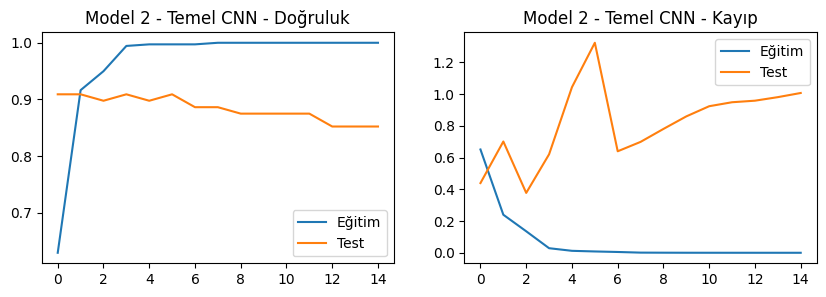

Model 2 Final Test Doğruluğu: %85.23


In [ ]:
# Eğitimi Başlat
print("Model 2 (Sıfırdan CNN) Eğitiliyor...")
history2 = model2.fit(train_generator, validation_data=validation_generator, epochs=15)

# Grafikleri Çiz
grafik_ciz(history2, "Model 2 - Temel CNN")

# Final Sonucu Yazdır
final_acc2 = history2.history['val_accuracy'][-1] * 100
print(f"Model 2 Final Test Doğruluğu: %{final_acc2:.2f}")